In [41]:
import sys
sys.path.append('../')
import re
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
matplotlib.style.use('ggplot')

In [8]:
!ls ../input

original  README.md


In [9]:
train_df = pd.read_csv('../input/original/train_round_0.csv')
test_df = pd.read_csv('../input/original/test_data_r0.csv')

In [15]:
print(train_df.shape, test_df.shape)
train_df.head(1)

(24843, 16) (4969, 13)


,answer,bridging_entity,content1,content2,content3,content4,content5,keyword,question,supporting_paragraph,title1,title2,title3,title4,title5,question_id
0,@content5@卡尔文森号航母@content5@,无,据美国媒体9月10日报道称，近日部署在美国东海岸多个军事基地的3艘核动力航母出现了罕见的一幕...,艾森豪威尔号航空母舰。它是美国尼米兹级核动力航空母舰的二号舰，舰名承袭自参加过第二次世界大战...,自2016年以来，美国海军第一次出现两艘核动力航母齐聚地中海的特殊部署，这意味着美国准备对某...,伊朗塔斯尼姆通讯社日前在社交媒体上发布了一段视频，视频中显示一艘航母在驱逐舰的护航下正在海面...,作为全世界唯一的超级大国，美国拥有10艘尼米兹核动力航母，其航母舰队和海军实力足以能够秒杀任...,“艾森豪威尔”号核动力航母,参与美韩举行的“鹞鹰”联合军演的是哪艘航母？,@content5@如今抵达西太平洋的美卡尔文森号航母，已经在该地区执行了一个多月的任务，并...,美军3艘核动力航母紧急机动，情况十分突然 高官：差点出了大事！,世界上最先进的航空母舰：艾森豪威尔号航空母舰！,局势十分紧张，美军两艘超级航母坐镇地中海 在向谁发出警告？,美航母抵近伊朗，伊战机紧急起飞，传回现场画面：甲板满是战机,美法曾联手包围俄航母 如今四国又来给中国添堵,Q_05193ghdyd


In [12]:
train_content1_len = train_df['content1'].str.len()
train_content2_len = train_df['content2'].str.len()
train_content3_len = train_df['content3'].str.len()
train_content4_len = train_df['content4'].str.len()
train_content5_len = train_df['content5'].str.len()

test_content1_len = test_df['content1'].str.len()
test_content2_len = test_df['content2'].str.len()
test_content3_len = test_df['content3'].str.len()
test_content4_len = test_df['content4'].str.len()
test_content5_len = test_df['content5'].str.len()

## document 长度分布

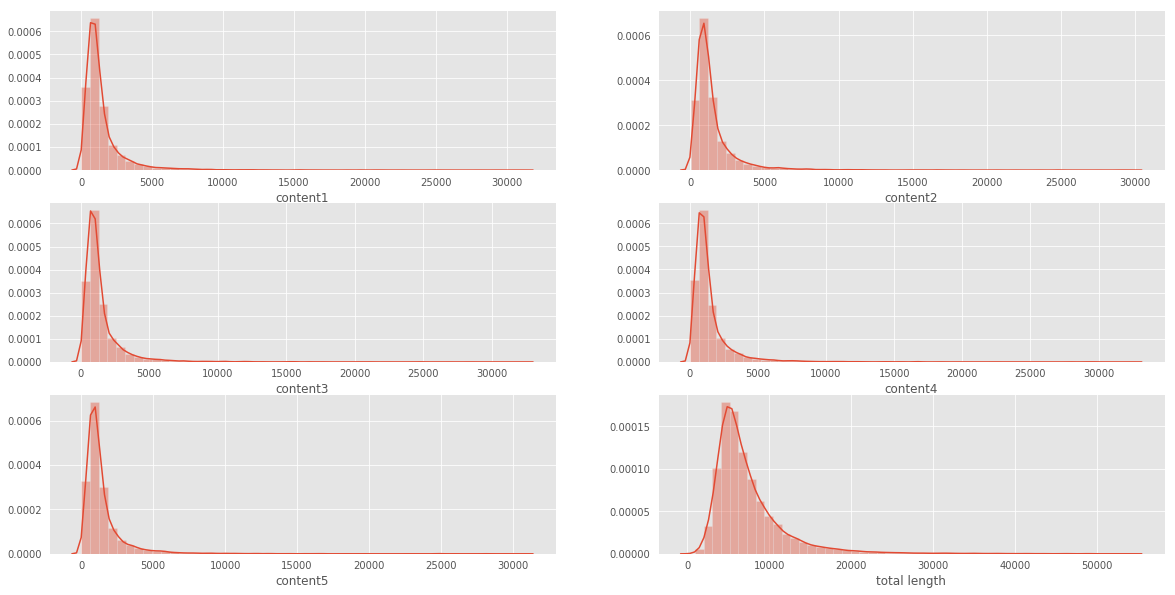

In [20]:
plt.figure(figsize=(20,10))
plt.subplot(321)
sns.distplot(train_content1_len)
plt.subplot(322)
sns.distplot(train_content2_len)
plt.subplot(323)
sns.distplot(train_content3_len)
plt.subplot(324)
sns.distplot(train_content4_len)
plt.subplot(325)
sns.distplot(train_content5_len)
plt.subplot(326)
sns.distplot(train_content1_len + train_content2_len + train_content3_len + 
             train_content4_len + train_content5_len, axlabel='total length')
plt.show()

## 答案长度分布

In [34]:
train_df['answer_str'] = train_df['answer'].str.replace('@content\d@', '')

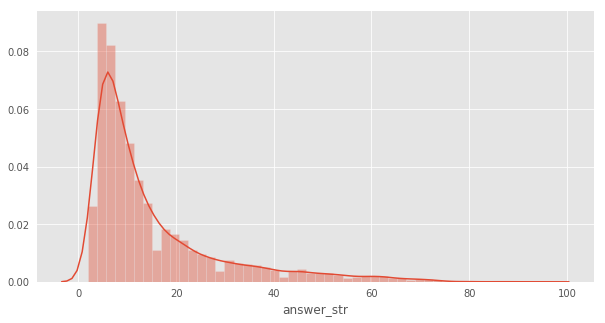

In [38]:
plt.figure(figsize=(10,5))
sns.distplot(train_df['answer_str'].str.len())
plt.show()

## 答案所在篇章分布

In [61]:
ans_pattern = re.compile(r'@content\d@')

def find_answer_in_docid(answer):
    docs = ans_pattern.findall(answer)
    return ','.join(list(set([doc[-2:-1] for doc in docs])))


In [62]:
train_df['answer_in_docid'] = train_df['answer'].map(find_answer_in_docid)

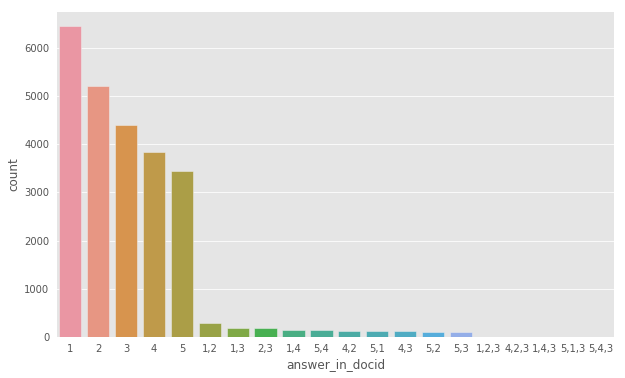

In [65]:
plt.figure(figsize=(10, 6))
sns.countplot(train_df['answer_in_docid'], order=train_df['answer_in_docid'].value_counts().index)
plt.show()

## 答案的基本模式，指导数据清洗策略

In [68]:
# 是否包含 url
train_df['answer_has_url'] = train_df['answer_str'].map(lambda x: 'http' in x or 'https' in x)

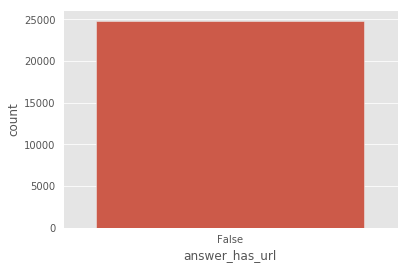

In [69]:
sns.countplot(train_df['answer_has_url'])

In [71]:
# 是否包含英文标点符号,!?等
train_df['answer_has_eng_punc'] = train_df['answer_str'].map(lambda x: ',' in x or '!' in x)

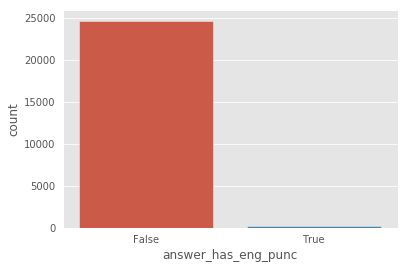

In [72]:
sns.countplot(train_df['answer_has_eng_punc'])

In [74]:
train_df['answer_str'][train_df['answer_has_eng_punc'] == True].head()

85                                               40,580吨
170    掠夺者最高速度可以达到每小时120公里。这款巨无霸的动力配置来自CUMMINS ISBe4柴...
234                   枪托与机匣配合紧密, 精度高, 线条流畅, 外形优雅的一贯优点. ,
333                                             61,170 吨
412                                             140,000把
Name: answer_str, dtype: object

## 问题和答案的对比

In [76]:
train_df[['question', 'answer_str']]

,question,answer_str
0,参与美韩举行的“鹞鹰”联合军演的是哪艘航母？,卡尔文森号航母
1,中菲关系焕发新的活力的好处是什么,实现了由转圜、巩固到提升的跨越式发展，为两国人民带来福祉，促进了地区和平稳定
2,海战开始，泰国海军一共损失了三艘什么艇？,鱼雷艇及吞武里号浅水重炮艇
3,"苏联把沙俄的""拉扎列夫海军上将""号改造后的重巡洋舰有多重？",8000多吨
4,AW－159 “野猫”直升机的机长是多少米？,15.22米
5,哪款手枪代替了鲁格P-08成为了德军的制式手枪？,沃尔特P-38
6,韩国空军现役主力战斗机是哪个？,F-15K
7,法国政界对法国总统的什么行为感到抵触？,让法国成为美国的附庸和木偶非常抵触。法国已经做好准备对叙利亚进行军事干预
8,桑普森具有什么能力？,多功能雷达探测和追踪中程弹道导弹的能力。
9,中越两国的“双料将军”是谁？,洪水将军
